In [ ]:
#pip install sionna
import yaml
from sionna.rt import *
import sionna.rt.scene as builtin_scenes
import mitsuba as mi
import torch
import random
from typing import Callable, Tuple, Optional, List
import numpy as np
import math
import matplotlib.pyplot as plt
import io
from PIL import Image
import tqdm
import plotly.graph_objs as go
import plotly.express as px
import pandas as pd
import json


from algorithm.pso_beam_searcher import PSOBeamSearcherTorch
from utils.compute_rss_pathsolver import compute_rss_from_path_solver
from algorithm.ga_beam_searcher import GABeamSearcherTorch
from utils.compute_precoding_vector import compute_precoding_vector_torch
from utils.plot_simulation import plot_simulation_summary
from generator import convert_simulation_summary_to_serializable

In [ ]:
# Load YAML config
with open("config.yaml", "r") as f:
    cfg = yaml.safe_load(f)


# Initialize scene
if cfg['scene']['built_in']!='none':
    scene = load_scene(getattr(builtin_scenes, cfg['scene']['name']))
else:
    file_path="/kaggle/input/sionna-yml/"+cfg['scene']['name']
    scene=load_scene(file_path)

scene.tx_array = PlanarArray(**cfg['scene']['transmitter_array'])
scene.rx_array = PlanarArray(**cfg['scene']['receiver_array'])

tx = Transmitter(**cfg['scene']['transmitter'])
rx = Receiver(**cfg['scene']['receiver'])
scene.add(tx)
scene.add(rx)
tx.look_at(rx)

camera = Camera(**cfg['scene']['camera'])

num_rows=cfg['scene']['transmitter_array']['num_rows']
num_cols=cfg['scene']['transmitter_array']['num_cols']
v_spacing=cfg['scene']['transmitter_array']['vertical_spacing']
h_spacing=cfg['scene']['transmitter_array']['horizontal_spacing']

In [ ]:
path_solver = PathSolver()
compute_rss_from_path_solver(torch.tensor([35,90]),torch.tensor([50,125]), path_solver, scene, num_rows, num_cols)

tensor([2.0897e-11, 2.2620e-11], device='cuda:0')

In [ ]:
if cfg["algorithm"]["name"].lower() == "pso":
    params = cfg["algorithm"]["params"]
    pso = PSOBeamSearcherTorch(
        fitness_fn = compute_rss_from_path_solver,
        path_solver = path_solver,
        scene = scene,
        num_cols = params["num_cols"],
        num_rows = params["num_rows"],
        population_size = params.get("population_size"),
        max_generations = params.get("max_generations"),
        w = params.get("w", 0.5),
        c1 = params.get("c1", 1.5),
        c2 = params.get("c2", 1.5),
        stagnant_limit = params.get("stagnant_limit"),
        seed_particle = tuple(params.get("seed_particle")),
        angle_unit = params.get("angle_unit"))

elif cfg["algorithm"]["name"].lower() == "ga":
    params = cfg["algorithm"]["params"]
    searcher = GABeamSearcherTorch(
        path_solver = path_solver,
        scene = scene,
        fitness_fn = compute_rss_from_path_solver,
        population_size = 50,
        max_generations = 100,
        mutation_rate = 0.7,
        crossover_rate = 0.5,
        seed_particle=(0, 0),
        search_limit=40,
        angle_bounds=((0, 90), (0, 360)),
        resolution=0.5,
        elite_count=3,
        stagnant_limit = 20,
        angle_unit='degree',
        num_cols = params["num_cols"],
        num_rows = params["num_rows"])


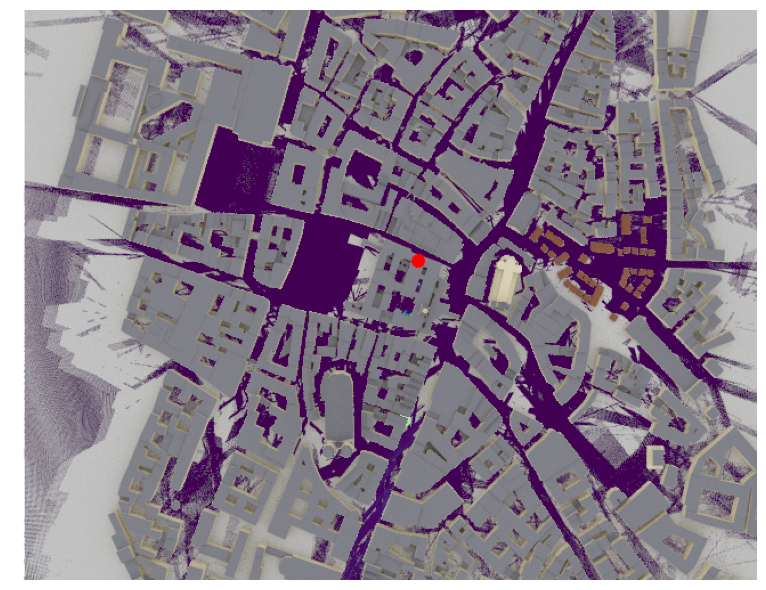

In [ ]:

precoding_vec = compute_precoding_vector_torch(num_rows, num_cols, v_spacing, h_spacing, torch.tensor([0]), torch.tensor([0])).cpu().numpy()

rm_solver=RadioMapSolver()
coverage_map = rm_solver(
    scene=scene,
    cell_size=[0.5, 0.5],
    samples_per_tx=int(1e7),
    max_depth=7,
    precoding_vec=(
        mi.TensorXf(precoding_vec.real.astype(np.float32)),
        mi.TensorXf(precoding_vec.imag.astype(np.float32))
    ),
    los=True,
    specular_reflection=True,
    diffuse_reflection=True,
    refraction=False
)

fig = scene.render(
        camera=camera,
        radio_map=coverage_map,
        rm_metric="rss",
        rm_db_scale=False
    )

In [ ]:
rss_start = compute_rss_from_path_solver(torch.tensor([0]),torch.tensor([0]), path_solver, scene, num_rows, num_cols).item()
# paths = path_solver(scene, max_depth = 5)

simulation_summary = []

# simulation_summary.append((0, 0, rss_start, h))
simulation_summary.append((0, 0, rss_start))

# Prepare to store frames
frames = []
buf = io.BytesIO()
fig.savefig(buf, format='png')
buf.seek(0)
frames.append(Image.open(buf))
plt.close(fig)
rm_solver = RadioMapSolver()
# Define receiver movement parameters
num_frames = 42
x_positions = np.linspace(-30, 180, num_frames)

for x in tqdm.tqdm(x_positions):
    # Update receiver position
    rx.position = np.array([-70, x, 1.5])

    theta, phi, rss = pso.search()
    print(rss)

    precoding_vec = compute_precoding_vector_torch(
        rows = num_rows,
        cols= num_cols,
        v_space = v_spacing,
        h_space = h_spacing, 
        theta_deg = theta.reshape(-1), 
        phi_deg = phi.reshape(-1)
    ).cpu().numpy()

    coverage_map = rm_solver(
        scene=scene,
        cell_size=[0.5, 0.5],
        samples_per_tx=int(1e7),
        max_depth=7,
        precoding_vec=(
            mi.TensorXf(precoding_vec.real.astype(np.float32)),
            mi.TensorXf(precoding_vec.imag.astype(np.float32))
        ),
        los=True,
        specular_reflection=True,
        diffuse_reflection=True,
        refraction=False
    )

    # h = path_solver(scene, max_depth=5).cir()[0]  # Just CIR tensor
    # simulation_summary.append((
    #     theta.item(),
    #     phi.item(),
    #     rss.item(),
    #     h
    # ))

    simulation_summary.append((
        theta.item(),
        phi.item(),
        rss.item()
    ))
    
    # Render scene with coverage map
    fig = scene.render(
        camera=camera,
        radio_map=coverage_map,
        rm_metric="rss",
        rm_db_scale=True
    )

    buf = io.BytesIO()

    # Save the figure to a BytesIO object
    fig.savefig(buf, format='png')
    buf.seek(0)
    frames.append(Image.open(buf))
    plt.close(fig)

frames[0].save(
    'coverage_animation.gif',
    save_all=True,
    append_images=frames[1:],
    duration=200,  # duration between frames in milliseconds
    loop=0  # loop indefinitely
)


  0%|          | 0/42 [00:00<?, ?it/s]

[GEN 000] RSS Max: 0.00 | Std: 0.0000
[STOP] RSS standard deviation below threshold: 0.0000
tensor(8.8160e-11, device='cuda:0')


  2%|▏         | 1/42 [00:01<00:41,  1.02s/it]

[GEN 000] RSS Max: 0.00 | Std: 0.0000
[STOP] RSS standard deviation below threshold: 0.0000
tensor(3.4755e-09, device='cuda:0')


  5%|▍         | 2/42 [00:02<00:40,  1.02s/it]

[GEN 000] RSS Max: 0.00 | Std: 0.0000
[STOP] RSS standard deviation below threshold: 0.0000
tensor(2.1508e-08, device='cuda:0')


  7%|▋         | 3/42 [00:03<00:39,  1.01s/it]

[GEN 000] RSS Max: 0.00 | Std: 0.0000
[STOP] RSS standard deviation below threshold: 0.0000
tensor(1.9551e-08, device='cuda:0')


 10%|▉         | 4/42 [00:04<00:38,  1.01s/it]

[GEN 000] RSS Max: 0.00 | Std: 0.0000
[STOP] RSS standard deviation below threshold: 0.0000
tensor(1.4008e-08, device='cuda:0')


 12%|█▏        | 5/42 [00:05<00:36,  1.00it/s]

[GEN 000] RSS Max: 0.00 | Std: 0.0000
[STOP] RSS standard deviation below threshold: 0.0000
tensor(1.2316e-08, device='cuda:0')


 14%|█▍        | 6/42 [00:06<00:35,  1.00it/s]

[GEN 000] RSS Max: 0.00 | Std: 0.0000
[STOP] RSS standard deviation below threshold: 0.0000
tensor(1.5813e-14, device='cuda:0')


 17%|█▋        | 7/42 [00:07<00:34,  1.00it/s]

[GEN 000] RSS Max: 0.00 | Std: 0.0000
[STOP] RSS standard deviation below threshold: 0.0000
tensor(8.2301e-09, device='cuda:0')


 19%|█▉        | 8/42 [00:08<00:34,  1.00s/it]

[GEN 000] RSS Max: 0.00 | Std: 0.0000
[STOP] RSS standard deviation below threshold: 0.0000
tensor(2.5305e-09, device='cuda:0')


 21%|██▏       | 9/42 [00:09<00:32,  1.00it/s]

[GEN 000] RSS Max: 0.00 | Std: 0.0000
[STOP] RSS standard deviation below threshold: 0.0000
tensor(6.6985e-11, device='cuda:0')


 24%|██▍       | 10/42 [00:10<00:31,  1.00it/s]

[GEN 000] RSS Max: 0.00 | Std: 0.0000
[STOP] RSS standard deviation below threshold: 0.0000
tensor(2.3216e-09, device='cuda:0')


 26%|██▌       | 11/42 [00:11<00:31,  1.01s/it]

[GEN 000] RSS Max: 0.00 | Std: 0.0000
[STOP] RSS standard deviation below threshold: 0.0000
tensor(2.0856e-09, device='cuda:0')


 29%|██▊       | 12/42 [00:12<00:30,  1.03s/it]

[GEN 000] RSS Max: 0.00 | Std: 0.0000
[STOP] RSS standard deviation below threshold: 0.0000
tensor(3.0366e-10, device='cuda:0')


 31%|███       | 13/42 [00:13<00:30,  1.03s/it]

[GEN 000] RSS Max: 0.00 | Std: 0.0000
[STOP] RSS standard deviation below threshold: 0.0000
tensor(3.9015e-15, device='cuda:0')


 33%|███▎      | 14/42 [00:14<00:28,  1.03s/it]

[GEN 000] RSS Max: 0.00 | Std: 0.0000
[STOP] RSS standard deviation below threshold: 0.0000
tensor(1.1045e-14, device='cuda:0')


 36%|███▌      | 15/42 [00:15<00:27,  1.03s/it]

[GEN 000] RSS Max: 0.00 | Std: 0.0000
[STOP] RSS standard deviation below threshold: 0.0000
tensor(1.8362e-09, device='cuda:0')


 38%|███▊      | 16/42 [00:16<00:27,  1.04s/it]

[GEN 000] RSS Max: 0.00 | Std: 0.0000
[STOP] RSS standard deviation below threshold: 0.0000
tensor(1.1328e-11, device='cuda:0')


 40%|████      | 17/42 [00:17<00:25,  1.03s/it]

[GEN 000] RSS Max: 0.00 | Std: 0.0000
[STOP] RSS standard deviation below threshold: 0.0000
tensor(2.5159e-10, device='cuda:0')


 43%|████▎     | 18/42 [00:18<00:24,  1.03s/it]

[GEN 000] RSS Max: 0.00 | Std: 0.0000
[STOP] RSS standard deviation below threshold: 0.0000
tensor(2.5851e-10, device='cuda:0')


 45%|████▌     | 19/42 [00:19<00:23,  1.04s/it]

[GEN 000] RSS Max: 0.00 | Std: 0.0000
[STOP] RSS standard deviation below threshold: 0.0000
tensor(1.5073e-13, device='cuda:0')


 48%|████▊     | 20/42 [00:20<00:22,  1.03s/it]

[GEN 000] RSS Max: 0.00 | Std: 0.0000
[STOP] RSS standard deviation below threshold: 0.0000
tensor(2.1334e-13, device='cuda:0')


 50%|█████     | 21/42 [00:21<00:21,  1.03s/it]

[GEN 000] RSS Max: 0.00 | Std: 0.0000
[STOP] RSS standard deviation below threshold: 0.0000
tensor(0., device='cuda:0')


 52%|█████▏    | 22/42 [00:22<00:20,  1.03s/it]

[GEN 000] RSS Max: 0.00 | Std: 0.0000
[STOP] RSS standard deviation below threshold: 0.0000
tensor(1.0355e-12, device='cuda:0')


 55%|█████▍    | 23/42 [00:23<00:19,  1.02s/it]

[GEN 000] RSS Max: 0.00 | Std: 0.0000
[STOP] RSS standard deviation below threshold: 0.0000
tensor(1.5790e-11, device='cuda:0')


 57%|█████▋    | 24/42 [00:24<00:18,  1.02s/it]

[GEN 000] RSS Max: 0.00 | Std: 0.0000
[STOP] RSS standard deviation below threshold: 0.0000
tensor(3.1576e-10, device='cuda:0')


 60%|█████▉    | 25/42 [00:25<00:17,  1.01s/it]

[GEN 000] RSS Max: 0.00 | Std: 0.0000
[STOP] RSS standard deviation below threshold: 0.0000
tensor(1.0131e-11, device='cuda:0')


 62%|██████▏   | 26/42 [00:26<00:16,  1.01s/it]

[GEN 000] RSS Max: 0.00 | Std: 0.0000
[STOP] RSS standard deviation below threshold: 0.0000
tensor(4.5288e-11, device='cuda:0')


 64%|██████▍   | 27/42 [00:27<00:15,  1.01s/it]

[GEN 000] RSS Max: 0.00 | Std: 0.0000
[STOP] RSS standard deviation below threshold: 0.0000
tensor(8.3094e-12, device='cuda:0')


 67%|██████▋   | 28/42 [00:28<00:14,  1.02s/it]

[GEN 000] RSS Max: 0.00 | Std: 0.0000
[STOP] RSS standard deviation below threshold: 0.0000
tensor(2.0383e-12, device='cuda:0')


 69%|██████▉   | 29/42 [00:29<00:13,  1.02s/it]

[GEN 000] RSS Max: 0.00 | Std: 0.0000
[STOP] RSS standard deviation below threshold: 0.0000
tensor(0., device='cuda:0')


 71%|███████▏  | 30/42 [00:30<00:12,  1.02s/it]

[GEN 000] RSS Max: 0.00 | Std: 0.0000
[STOP] RSS standard deviation below threshold: 0.0000
tensor(4.0638e-11, device='cuda:0')


 74%|███████▍  | 31/42 [00:31<00:11,  1.01s/it]

[GEN 000] RSS Max: 0.00 | Std: 0.0000
[STOP] RSS standard deviation below threshold: 0.0000
tensor(3.2101e-11, device='cuda:0')


 76%|███████▌  | 32/42 [00:32<00:10,  1.02s/it]

[GEN 000] RSS Max: 0.00 | Std: 0.0000
[STOP] RSS standard deviation below threshold: 0.0000
tensor(0., device='cuda:0')


 79%|███████▊  | 33/42 [00:33<00:09,  1.02s/it]

[GEN 000] RSS Max: 0.00 | Std: 0.0000
[STOP] RSS standard deviation below threshold: 0.0000
tensor(0., device='cuda:0')


 81%|████████  | 34/42 [00:34<00:08,  1.01s/it]

[GEN 000] RSS Max: 0.00 | Std: 0.0000
[STOP] RSS standard deviation below threshold: 0.0000
tensor(0., device='cuda:0')


 83%|████████▎ | 35/42 [00:35<00:07,  1.01s/it]

[GEN 000] RSS Max: 0.00 | Std: 0.0000
[STOP] RSS standard deviation below threshold: 0.0000
tensor(1.2209e-10, device='cuda:0')


 86%|████████▌ | 36/42 [00:36<00:06,  1.02s/it]

[GEN 000] RSS Max: 0.00 | Std: 0.0000
[STOP] RSS standard deviation below threshold: 0.0000
tensor(4.2192e-11, device='cuda:0')


 88%|████████▊ | 37/42 [00:37<00:05,  1.01s/it]

[GEN 000] RSS Max: 0.00 | Std: 0.0000
[STOP] RSS standard deviation below threshold: 0.0000
tensor(2.2595e-12, device='cuda:0')


 90%|█████████ | 38/42 [00:38<00:04,  1.01s/it]

[GEN 000] RSS Max: 0.00 | Std: 0.0000
[STOP] RSS standard deviation below threshold: 0.0000
tensor(0., device='cuda:0')


 93%|█████████▎| 39/42 [00:39<00:03,  1.00s/it]

[GEN 000] RSS Max: 0.00 | Std: 0.0000
[STOP] RSS standard deviation below threshold: 0.0000
tensor(0., device='cuda:0')


 95%|█████████▌| 40/42 [00:40<00:02,  1.00s/it]

[GEN 000] RSS Max: 0.00 | Std: 0.0000
[STOP] RSS standard deviation below threshold: 0.0000
tensor(1.1198e-12, device='cuda:0')


 98%|█████████▊| 41/42 [00:41<00:01,  1.00s/it]

[GEN 000] RSS Max: 0.00 | Std: 0.0000
[STOP] RSS standard deviation below threshold: 0.0000
tensor(0., device='cuda:0')


100%|██████████| 42/42 [00:42<00:00,  1.01s/it]


In [ ]:
plot_simulation_summary(simulation_summary)

serializable_data = convert_simulation_summary_to_serializable(simulation_summary)
with open("simulation_summary.json", "w") as f:
    json.dump(serializable_data, f, indent=4)